# <font color='blue'>Rough Bergomi Tree</font>

1. Understand Jim's notebook on how to calibrate $(H, \rho, \nu)$ based on market smile data.
2. Given a set of smiles, possibly at differnt expiries $\tau$, estimate $(H, \rho, \nu)$ .
3. ~~Implement the data structure of bushy rBergomi tree.~~
4. Implement forward evolution of stock:
    - ~~forward evolution of $B_t$;~~
    - ~~forward evolution of $W_t$ and $\varphi(t)=\mathcal{G}^{\alpha}(W_t)$, where $\alpha = H-1/2$, or $2\alpha+1=2H$;~~
    - ~~valuation of $\Phi(\varphi)(t) = \xi_0(t) \exp[2\nu C_H \varphi(t)-2\nu^2 C_H^2 \int_0^t (t-s)^{2\alpha}ds] = \xi_0(t) \exp[2\nu C_H \varphi(t)-\nu^2 C_H^2 t^{2H}/H]$. Initially, $\Phi(\varphi)(t=0)=\xi_0(0)$;~~
    - ~~forward evolution of $X_t$.~~
5. Implement backward valuation of a European option:
    - ~~Set terminal payoff;~~
    - ~~Given $(H, \rho, \nu, S_0, K, r, q, \xi_0(\tau))$, return an option price;~~
    - ~~Given $(\rho, \nu, S_0, K, r, q, \xi_0(\tau))$ and a range of $H$'s, return a list of option prices;~~
    - ~~Use Black-Scholes formula to generate the vanilla smile.~~
6. Implement backward valuation of an American option:
    - Given $(H, \rho, \nu, S_0, K, r, q, \xi_0(\tau))$, return an option price;
    - Given $(\rho, \nu, S_0, K, r, q, \xi_0(\tau))$ and a range of $H$'s, return a list of option prices;
7. Take difference between the European option prices and the American optoin prices to get the early exercise premium, over a range of moneyness.
8. Loop over a variety of Hurst $H$'s with $(\rho, \nu)$ calibrated to the given market smile data.

In [3]:
import numpy as np
import pandas as pd
import math
import scipy.integrate
import scipy.optimize
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
import networkx as nx

%matplotlib inline
import matplotlib.pyplot as plt

from black_model import black_impv
from structure import *

In [4]:
g_DEBUG = False

## <font color='gray'>Parameters</font>

In [5]:
# User-input parameters:

# Time horizon 
T = 1.0
# Number of time intervals
N = 8
# Hurst exponent
H = 0.3
# Correlation
rho = -0.9
# Coefficient of fractional BM
nu = 1.0
# Current value of variance
xi0 = 0.04
# Current value of stock
S0 = 1.0
# Method to evolve stocks
EVOLVE_METHOD='dLogS'
# Forward variance curve
def fvc(t): return xi0

# The following are derived intermedate parameters. DO NOT CHANGE.

# binomial map:
# 0: xi = +1, zeta = +1
# 1: xi = +1, zeta = -1
# 2: xi = -1, zeta = +1
# 3: xi = -1, zeta = -1
bmap = [(1,1),(1,-1),(-1,1), (-1,-1)]
dt = T/N
rdt = math.sqrt(dt)
rho2 = math.sqrt(1-rho*rho)
alpha = H - 0.5
twoH = 2*H
CH = math.sqrt((2*H*math.gamma(1.5-H))/(math.gamma(0.5+H)*math.gamma(2-2*H)))
twoNuCH = 2*nu*CH
NuCH2H = nu*nu*CH*CH/H
X0 = math.log(S0)
p = 0.25
assert EVOLVE_METHOD in {'dS', 'dLogS'}
DLOGS = True if EVOLVE_METHOD == 'dLogS' else False
NN = total_num_nodes(N)

print("Time horizon:", T)
print("Number of time steps:", N)
print("Time step width:", dt)
print("Square root of time step:", round(rdt, 3))
print("Hurst parameter H:", H)
print("Correlation coefficient 1:", rho)
print("Correlation coefficient 2:", round(rho2,3))
print("Volatility of volatility:", nu)
print("Forward variance curve (flat):", xi0)
print("α: ", alpha)
print("2H:", twoH)
print("C_H:", round(CH,6))
print("2*ν*C_H:", round(twoNuCH,6))
print("ν^2*C_H^2/H:", round(NuCH2H,6))
print("S0:", S0)
print("X0:", round(X0, 6))
print("Transition probability:", p)
print("Evolution method:", EVOLVE_METHOD)
print("Total number of nodes:", NN)

Time horizon: 1.0
Number of time steps: 8
Time step width: 0.125
Square root of time step: 0.354
Hurst parameter H: 0.3
Correlation coefficient 1: -0.9
Correlation coefficient 2: 0.436
Volatility of volatility: 1.0
Forward variance curve (flat): 0.04
α:  -0.2
2H: 0.6
C_H: 0.730283
2*ν*C_H: 1.460566
ν^2*C_H^2/H: 1.777711
S0: 1.0
X0: 0.0
Transition probability: 0.25
Evolution method: dLogS
Total number of nodes: 87381


## <font color='gray'>Volatility Tree</font>

In [6]:
G = np.zeros(NN)
G[0] = 0.0

for nn in range(1, NN):
    path = path_from_index(nn)
    n = len(path)
    GW = 0.0
    for k in range(n):
        move = path[k]
        xi, zeta = bmap[move][0], bmap[move][1]
        GW += xi*(((n-k)*dt)**alpha)
    GW *= rdt
    G[nn] = GW
    
for n in range(N):
    nn1 = total_num_nodes(n)
    nn2 = total_num_nodes(n+1)
    print(n+1, round(G[nn1:nn2].min(),3), round(G[nn1:nn2].max(),3))

1 -0.536 0.536
2 -1.002 1.002
3 -1.433 1.433
4 -1.839 1.839
5 -2.227 2.227
6 -2.602 2.602
7 -2.965 2.965
8 -3.318 3.318


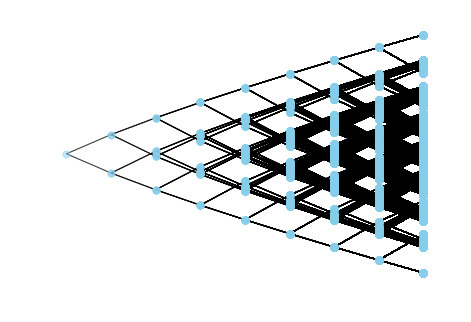

H = 0.3


In [7]:
G1=nx.Graph()

# Draw nodes
for i in range(NN,0,-1):
    nn = i-1
    path = path_from_index(nn)
    n = len(path)
    t = n*dt
    G1.add_node(i,pos=(t,G[nn]))

# Draw edges
for i in range(NN,1,-1):
    nn = i-1
    path = path_from_index(nn)
    move = path[-1]
    prev_nn = (nn-move-1)//4
    j = prev_nn+1
    G1.add_edge(i,j)

pos=nx.get_node_attributes(G1,'pos')
nx.draw(G1,pos,node_size=50,node_color="skyblue",alpha=0.5)

plt.rcParams["figure.figsize"] = (10,6)
plt.show()
print("H =", H)

## <font color='gray'>Forward Evolution in Time</font>

In [8]:
# Allocation
X = np.zeros(NN)

# Initialization
if DLOGS: X[0] = X0
else: X[0] = S0

# Fill X at time step #1
nn1 = total_num_nodes(0)
nn2 = total_num_nodes(1)
for nn in range(nn1,nn2):
    ########################################################################
    path = path_from_index(nn)
    move = path[0]
    xi, zeta = bmap[move][0], bmap[move][1]
    Phi = fvc(0)
    PhiDt = Phi*dt
    rPhiDt = math.sqrt(PhiDt)
    if DLOGS: X[nn] = X[0]-0.5*PhiDt+rPhiDt*(rho*xi+rho2*zeta)
    else: X[nn] = X[0]*(1+rPhiDt*(rho*xi+rho2*zeta))
    ########################################################################
    if g_DEBUG: 
        logstr = "Time 1: (" + str(xi) + "," + str(zeta) + "), X[prev_n] =" + str(round(X[0], 3)) + ", σ×dB = " + str(round(-0.5*PhiDt+rPhiDt*(rho*xi+rho2*zeta),3)) + ", X[n] = " + str(round(X[0]-0.5*PhiDt+rPhiDt*(rho*xi+rho2*zeta), 3))
        print(logstr)

# Fill X at later time steps
for nn in range(nn2, NN):
    ########################################################################
    path = path_from_index(nn)
    n = len(path)
    t = n*dt
    prev_t = (n-1)*dt
    t2H = prev_t**twoH
    #print(path, n, t, prev_t, t2H)
    ########################################################################
    GW = 0.0
    for k in range(n-1):
        move = path[k]
        xi, zeta = bmap[move][0], bmap[move][1]
        GW += xi*(((n-1-k)*dt)**alpha)
    GW *= rdt
    Phi = fvc(prev_t)*math.exp(twoNuCH*GW-NuCH2H*t2H)
    PhiDt = Phi*dt
    rPhiDt = math.sqrt(PhiDt)
    ########################################################################
    move = path[-1]
    prev_nn = (nn-move-1)//4
    xi, zeta = bmap[move][0], bmap[move][1]
    if DLOGS: X[nn] = X[prev_nn]-0.5*PhiDt+rPhiDt*(rho*xi+rho2*zeta)
    else: X[nn] = X[prev_nn]*(1+rPhiDt*(rho*xi+rho2*zeta))
    ########################################################################

    if g_DEBUG:
        logstr = "Time " + str(n) + ": "
        ####################################################
        prev_path = path_from_index(prev_nn)
        for k in range(len(prev_path)):
            move = prev_path[k]
            xi, zeta = bmap[move][0], bmap[move][1]
            logstr += "(" + str(xi) + "," + str(zeta) + ")"
        ####################################################
        if len(prev_path)>0: logstr += " -> "
        for k in range(n):
            move = path[k]
            xi, zeta = bmap[move][0], bmap[move][1]
            logstr += "(" + str(xi) + "," + str(zeta) + "),"
        logstr += " X[prev_n] =" + str(round(X[prev_nn], 3)) + ", σ×dB = " + str(round(-0.5*PhiDt+rPhiDt*(rho*xi+rho2*zeta),3)) + ", X[n] = " + str(round(X[prev_nn]-0.5*PhiDt+rPhiDt*(rho*xi+rho2*zeta), 3))  + ", GW =" + str(round(GW, 3))
        ####################################################
        print(logstr)

if DLOGS: X = np.exp(X)
#if g_DEBUG: print(X)

## <font color='gray'>Check Terminal Martingality</font>

In [9]:
# Terminal
EX = 0.0
NI = start_index_at_step(N)
for nn in range(NI, NN):
    EX += X[nn]
EX /= (NN-NI)
print("E[X(T)] =", EX)

E[X(T)] = 0.999985813877


## <font color='gray'>Visualization of Stock Evolutions</font>

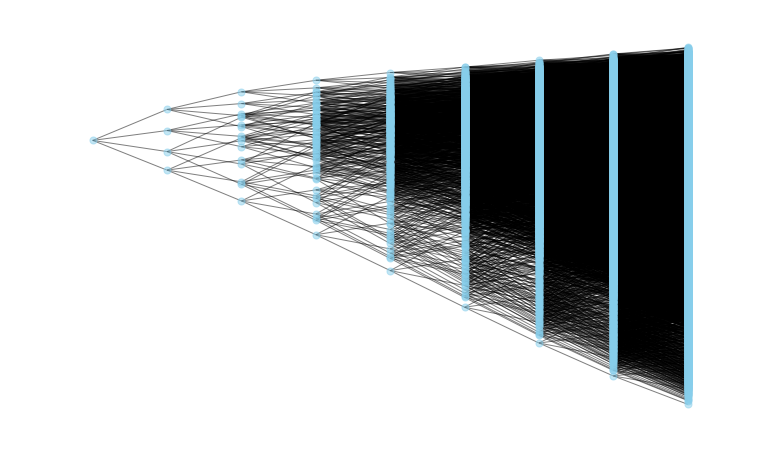

H = 0.3


In [10]:
G2=nx.Graph()

# Draw nodes
for i in range(NN,0,-1):
    nn = i-1
    path = path_from_index(nn)
    n = len(path)
    t = n*dt
    G2.add_node(i,pos=(t,X[nn]))

# Draw edges
for i in range(NN,1,-1):
    nn = i-1
    path = path_from_index(nn)
    move = path[-1]
    prev_nn = (nn-move-1)//4
    j = prev_nn+1
    G2.add_edge(i,j)

pos=nx.get_node_attributes(G2,'pos')
nx.draw(G2,pos,node_size=50,node_color="skyblue",alpha=0.5)

plt.rcParams["figure.figsize"] = (10,6)
plt.show()
print("H =", H)

In [11]:
NI = start_index_at_step(N)
Xmin = X[NI:NN].min()
Xmax = X[NI:NN].max()
print("X.min =", round(Xmin,3), ", X.max =", round(Xmax,3))
print("Log X.min =", round(np.log(Xmin),3), ", Log X.max =", round(np.log(Xmax),3))

X.min = 0.18 , X.max = 1.289
Log X.min = -1.717 , Log X.max = 0.254


## <font color='gray'>Sample Strikes</font>

In [12]:
# Strikes
num_moneyness = 60
moneyness_pixel = (np.log(Xmax) - np.log(Xmin))/60
LogMoneyness_list = np.linspace(np.log(Xmin)+moneyness_pixel, np.log(Xmax)+moneyness_pixel, num=num_moneyness)
Klist = S0*np.exp(LogMoneyness_list)

## <font color='gray'>Backward Valuation of European Options</font>

In [21]:
def price_either_call_or_put(Klist, opttype, N, X, earlyexercise):

    NN = total_num_nodes(N)
    assert len(X) == NN
    assert opttype in {1,-1}
    
    Vlist = []
    for K in Klist:
        # Initialization
        V = np.zeros(NN)

        # Terminal payoff
        NI = start_index_at_step(N)
        for nn in range(NI, NN):
            if opttype == 1: v = X[nn]-K
            else: v = K-X[nn]
            if v>0: V[nn] = v

        # Backward valuation
        for n in range(N,0,-1):
            NI = start_index_at_step(n)
            NF = start_index_at_step(n+1)
            for nn in range(NI, NF):
                path = path_from_index(nn)
                move = path[-1]
                prev_nn = (nn-move-1)//4
                V[prev_nn] += p*V[nn]
                
            if earlyexercise:
                for nn in range(NI, NF):
                    if opttype == 1: v = X[prev_nn]-K
                    else: v = K-X[prev_nn]

                    if v > V[prev_nn]:
                        V[prev_nn] = v

        if earlyexercise:
            print("K:", K, ", American:", V[0])
        else:
            print("K:", K, ", Eurpoean:", V[0])
        Vlist.append(V[0])
        
    return Vlist

def price_both_call_and_put(call_Klist, put_Klist, N, X):
    
    call_Vlist = price_either_call_or_put(call_Klist, 1, N, X)
    put_Vlist = price_either_call_or_put(put_Klist, -1, N, X)
    return call_Vlist, put_Vlist

In [23]:
Klist = [1.0, 1.1]
Vlist = price_either_call_or_put(Klist, -1, N, X, True)

K: 1.0 , American: 0.0594086821624
K: 1.1 , American: 0.114454634758


## <font color='gray'>Implied Volatilities</font>

In [15]:
σList = []
for k, v in zip(Klist, Vlist): σList.append(black_impv(k, T, S0, v, 1))

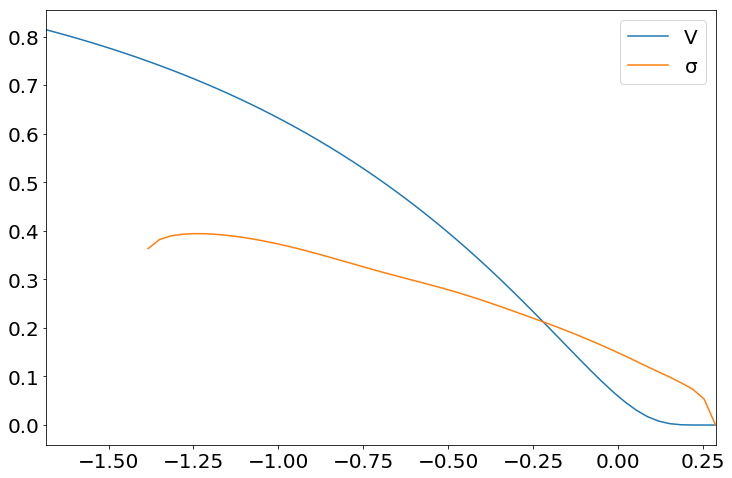

In [16]:
df = pd.DataFrame(index=np.log(Klist))
df["K"] = Klist
df["V"] = Vlist
df["σ"] = σList
fig, axes = plt.subplots()
fontsize = 20
df[ ["V", "σ"] ].plot(fontsize=fontsize, ax=axes, figsize=(12,8))
plt.legend(prop={'size':fontsize})

In [17]:
df

,K,V,σ
-1.684153,0.185602,8.143843e-01,NaN
-1.650742,0.191907,8.080785e-01,NaN
-1.617331,0.198428,8.015587e-01,NaN
-1.583919,0.205169,7.948175e-01,NaN
-1.550508,0.212140,7.878476e-01,NaN
-1.517097,0.219348,7.806413e-01,NaN
-1.483686,0.226800,7.731908e-01,NaN
-1.450275,0.234506,7.654880e-01,NaN
-1.416864,0.242473,7.575244e-01,NaN
-1.383452,0.250711,7.492915e-01,0.363438
